<a href="https://colab.research.google.com/github/cathemesquita/Colab_notebooks/blob/main/PROJETO_LH_PFC_GRANGER_E_COH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


> # BIBLIOTECAS

In [ ]:
from IPython.display import clear_output

In [ ]:
pip install open-ephys-python-tools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.8/381.8 kB 3.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for open-ephys-python-tools: filename=open_ephys_python_tools-0.1.7-py3-none-any.whl size=39989 sha256=809f14d44b5f24a382322d7d98135bb9b6f123f50f11f0aa19541f01501433b0
  Stored in directory: /root/.cache/pip/wheels/99/0a/29/c0d2d399ff078b2a96c61e36a0a219a8fbb545a7acd261ce80
  Created wheel for zmq: filename=zmq-0.0.0-py3-none-any.whl size=1264 sha256=aff6bd782ac4bf82c4e7ea4e232c939c5fc5bd6a9819efafcc4d00d17752c51f
  Stored in directory: /root/.cache/pip/wheels/ab/c5/fe/d853f71843cae26c123d37a7a5934baac20fc66f35a913951d
Successfully built open-ephys-python-tools zmq


In [ ]:
! pip install pactools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 14.6 MB/s eta 0:00:00


In [ ]:
from open_ephys.analysis import Session

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import numpy as np
import pandas as pd


from scipy import signal
import math
from scipy.signal import welch, spectrogram, coherence, find_peaks, firwin, lfilter, filtfilt, hilbert
import seaborn as sn

from statsmodels.tsa.stattools import grangercausalitytests
from scipy import stats
from scipy.stats import wilcoxon

import math
import time as ttime
from numpy.fft import fft, ifft, rfft, fftfreq
from scipy.signal import firwin, lfilter, filtfilt
from scipy.io import loadmat

import pactools
from pactools import Comodulogram, REFERENCES

import os
from PIL import Image
from scipy import signal



import seaborn as sns

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

> # FUNÇÕES



In [ ]:
def prewiew(path):
  load = Session(path).recordnodes[0].recordings[0]
  t_raw= load.continuous[0].timestamps
  t = t_raw-t_raw[0]

  data = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t)))

  srate = 1000
  fc_low = 45
  fc_high = 65
  order = 3
  b, a = signal.butter(order, [fc_low/(0.5*srate), fc_high/(0.5*srate)], btype='bandstop')

  data_filt = signal.filtfilt(b, a, data)

  return (pd.DataFrame(data_filt))


In [ ]:
def preview_plot(data):

  for i in range(0,32):
    plt.figure()
    plt.plot(data[i])
    plt.title('ch' + str (i+1))

In [ ]:
def contador_de_tempo(data_para_contar):
  total_time = 0
  for i in range(len(data_para_contar)):
    total_time = total_time+ len(data_para_contar[i])/srate

  return total_time

In [ ]:
# CARREGAR O DADO COMPLETO

def load_data_full(path,ch_prl,ch_cg,ch_il):
  load = Session(path).recordnodes[0].recordings[0]
  t_raw= load.continuous[0].timestamps
  t = t_raw-t_raw[0]

  # tive que ecolher esse len pq o CCM559 tinha 30 min de dado, então padronizei p todos 10min
  data_prl = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,int(int(ch_prl)-1)]
  data_cg = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,int(int(ch_cg)-1)]
  data_il = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,int(int(ch_il)-1)]


  srate = 1000
  fc_low = 59
  fc_high = 61
  order = 5
  b, a = signal.butter(order, [fc_low/(0.5*srate), fc_high/(0.5*srate)], btype='bandstop')

  PRL = signal.filtfilt(b, a, data_prl)
  CG = signal.filtfilt(b, a, data_cg)
  IL = signal.filtfilt(b, a, data_il)

  return(pd.DataFrame({'data_PRL': PRL,'data_CG': CG, 'data_IL': IL}))

In [ ]:
# CARREGAR OS DADOS DO ACELEROMETRO

def load_acelerometer(path):
    load = Session(path).recordnodes[0].recordings[0]
    t_raw = load.continuous[0].timestamps
    t = t_raw - t_raw[0]

    x = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:, 32]
    y = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:, 33]
    z = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:, 34]

    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    acel = np.abs(np.sqrt(x**2 + y**2 + z**2))

    df_acel = pd.DataFrame({'acel': acel})
    df_acel['animal'] = str(rato)
    df_acel['condicao'] = str(condicao)

    return df_acel

In [ ]:
def generating_masks_parado(path,ch,regiao): #ANIMAL PARADO

  load = Session(path).recordnodes[0].recordings[0]
  t_raw= load.continuous[0].timestamps
  t = t_raw-t_raw[0]

  data = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,int(int(ch)-1)]

  srate = 1000
  fc_low = 59
  fc_high = 61
  order = 5
  b, a = signal.butter(order, [fc_low/(0.5*srate), fc_high/(0.5*srate)], btype='bandstop')

  DATA = signal.filtfilt(b, a, data)

  # Recuperando dado da acelerometria para definir momentos de atividade
  data_acel = df_acel[(df_acel['animal'] == str(rato) ) & (df_acel['condicao'] == str(condicao))]['acel']

  acel = np.array(data_acel)
  acel = np.diff(acel, axis = 0)
  acel = abs(pd.DataFrame(acel)).rolling(window=1000).mean()

  # array booleano dizendo onde animal mexeu e não mexeu
  parado_bool = np.array(acel <= 0.005 )
  parado_bool = np.append(parado_bool, 0) #aqui foi adicionado um 0 pois a função diff retira um elemento do vetor, assim ele volta ao tamanho original


  index_parado_all = []
  for x in range(len(parado_bool)):
      if parado_bool[x] == True:
        index_parado_all.append(x)


  condition = (DATA >= -400) & (DATA <= 400) #eliminando ruídos

  index_sem_ruido = []

  for k in range(len(condition)):
      if condition[k] == True:
          index_sem_ruido.append(k)

  intersection = np.intersect1d(index_parado_all, index_sem_ruido) #fazendo a interseção entre condição(animal parado) e eliminação de ruídos

  vector_nan = np.full(len(DATA), np.nan)

  vector_nan[intersection] = DATA[intersection]


  # Essa parte do código irá retirar pedaços muito curtos de dado (menos de 2s)
  groups = find_consecutive_groups(vector_nan)

  for start, end in groups:
      length = end - start
      if length < 2000:
            vector_nan[start:end] = np.nan #transforma pedaços menores que 2s em Nan

  mask = np.where(~np.isnan(vector_nan))[0] #pegando apenas os indices dos valores que não são Nan


  return(pd.DataFrame({'MASK': mask, 'regiao': regiao}))

In [ ]:
def generating_masks_ativo(path,ch,regiao): #ANIMAL ATIVO

  load = Session(path).recordnodes[0].recordings[0]
  t_raw= load.continuous[0].timestamps
  t = t_raw-t_raw[0]

  data = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,int(int(ch)-1)]

  srate = 1000
  fc_low = 59
  fc_high = 61
  order = 5
  b, a = signal.butter(order, [fc_low/(0.5*srate), fc_high/(0.5*srate)], btype='bandstop')

  DATA = signal.filtfilt(b, a, data)

  # Recuperando dado da acelerometria para definir momentos de atividade
  data_acel = df_acel[(df_acel['animal'] == str(rato) ) & (df_acel['condicao'] == str(condicao))]['acel']

  acel = np.array(data_acel)
  acel = np.diff(acel, axis = 0)
  acel = abs(pd.DataFrame(acel)).rolling(window=1000).mean()

  # array booleano dizendo onde animal mexeu e não mexeu
  ativo_bool = np.array(acel >= 0.005 )
  ativo_bool = np.append(ativo_bool, 0) #aqui foi adicionado um 0 pois a função diff retira um elemento do vetor, assim ele volta ao tamanho original


  index_ativo_all = []
  for x in range(len(ativo_bool)):
      if ativo_bool[x] == True:
        index_ativo_all.append(x)


  condition = (DATA >= -400) & (DATA <= 400) #eliminando ruídos

  index_sem_ruido = []

  for k in range(len(condition)):
      if condition[k] == True:
          index_sem_ruido.append(k)

  intersection = np.intersect1d(index_ativo_all, index_sem_ruido) #fazendo a interseção entre condição(animal parado) e eliminação de ruídos

  vector_nan = np.full(len(DATA), np.nan)

  vector_nan[intersection] = DATA[intersection]


  # Essa parte do código irá retirar pedaços muito curtos de dado (menos de 2s)
  groups = find_consecutive_groups(vector_nan)

  for start, end in groups:
      length = end - start
      if length < 2000:
            vector_nan[start:end] = np.nan #transforma pedaços menores que 2s em Nan

  mask = np.where(~np.isnan(vector_nan))[0] #pegando apenas os indices dos valores que não são Nan


  return(pd.DataFrame({'MASK': mask, 'regiao': regiao}))

In [ ]:

# Identificar os grupos de índices consecutivos não-NaN e seus comprimentos para cortar momentos de imobilidade menores que 2s
def find_consecutive_groups(arr):
    # Encontrar as mudanças de NaN para não-NaN e vice-versa
    diff = np.diff(np.isnan(arr).view(np.int8))
    idx, = diff.nonzero()

    # Adicionar o índice do primeiro e último elemento
    idx = np.r_[0, idx + 1, len(arr)]
    idx_pairs = zip(idx[:-1], idx[1:])  # Formar pares de índices

    return [(start, end) for start, end in idx_pairs if not np.isnan(arr[start])]

In [ ]:
def media_coherence(df, condicao, r1, r2):
    filtro = (df['condicao'] == condicao) & (df['r1'] == r1) & (df['r2'] == r2)
    media_coherence = df[filtro].groupby('indice')['coherence'].mean()
    result_df = pd.DataFrame({'coherence': media_coherence,'r1': r1,'r2': r2,'condicao': condicao, 'regioes': str(r1)+'->'+str(r2)})
    return (result_df)

In [ ]:
def get_psd( data_psd  ):

  f, p = welch(data_psd, fs = 1000,nperseg = 1000, noverlap = int(0.9*1000), nfft = 10*1000)
  df_psd = pd.DataFrame({'PSD': p, 'F': f})

  return(df_psd )

In [ ]:
# Função para mapear o valor da frequencia da coerencia para o nome da banda
def mapear_banda(valor):
    if 0 <= valor <= 4:
        return 'Delta'
    elif 5 <= valor <= 10:
        return 'Theta'
    elif 11 <= valor <= 29:
        return 'Alpha/beta'
    elif 30 <= valor <= 50:
        return 'Low gamma'
    elif 51 <= valor <= 90:
        return 'Mid gamma'
    else:
        return 'High gamma'

In [ ]:
def tempo_para_pontos(tempo):
    minutos, segundos = map(int, tempo.split(':'))
    total_segundos = minutos * 60 + segundos
    pontos = total_segundos * 1000
    return pontos

In [ ]:

def eegfilt(data,srate,flow,fhigh):

    # fir LS
    trans = 0.15
    nyq = srate*0.5
    f=[0, (1-trans)*flow/nyq, flow/nyq, fhigh/nyq, (1+trans)*fhigh/nyq, 1]
    m=[0,0,1,1,0,0]
    filt_order = 3*np.fix(srate/flow)
    if filt_order % 2 == 0:
        filt_order = filt_order + 1

    filtwts = signal.firls(filt_order,f,np.double(m))
    data_filt = signal.filtfilt(filtwts,1, data)

    return(data_filt)

In [ ]:
#ExTRAINDO O MODULATION INDEX

def modulation_index(amp,fase_lenta,numbin):

    position=np.zeros(numbin) # this variable will get the beginning (not the center) of each phase bin (in rads)
    winsize = 2*np.pi/numbin # bin de fase

    position = []
    for j in np.arange(1,numbin+1):
        position.append(-np.pi+(j-1)*winsize)

    nbin=numbin
    mean_amp = []
    for j in np.arange(0,nbin):
        boolean_array = np.logical_and(fase_lenta >=  position[j], fase_lenta < position[j]+winsize)
        I = np.where(boolean_array)[0]
        mean_amp.append(np.mean(amp[I]))

    mean_amp = [x for x in mean_amp if str(x) != 'nan']
    p = mean_amp/np.sum(mean_amp)

    entrop = -1*(np.sum(p*np.log(p)))
    mi = (np.log(numbin)-entrop)/np.log(numbin)

    return(mi)

In [ ]:
import random

def generating_surrogatos(lfp,numero_surrogatos):
    surrogatos = []
    for i in range(numero_surrogatos):
        split = random.randint(1, 90000)
        surro = np.concatenate([lfp[split:], lfp[:split]])
        surrogatos.append(surro)
    return surrogatos

In [ ]:
# ACOP FASE AMPL PARA UMA REGIÃO

def pac(lfp,lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,srate,numbin,mask):

    AmpFreqTransformed1 = []
    PhaseFreq = []

    pac_mi = []

    for ii in altaVector:
        Af1 = ii
        Af2=Af1+alta_BandWidth

        AmpFreq1=eegfilt(lfp,srate,Af1,Af2) # just filtering

        analytic_signal1 = signal.hilbert(AmpFreq1)
        AmpFreqTransformed1.append(np.abs(analytic_signal1)[mask])

    faselenta = []
    for jj in lentaVector:
        Pf1 = jj
        Pf2 = Pf1 + lenta_BandWidth
        PhaseFreq=eegfilt(lfp,srate,Pf1,Pf2)
        analytic_signal = signal.hilbert(PhaseFreq)
        faselenta.append(np.angle(analytic_signal)[mask])

    fase_lenta = faselenta

    comodulogram = np.empty((len(lentaVector),len(altaVector)))

    for count_lenta,lenta in enumerate(fase_lenta):

        for count_rapida,rapida in enumerate(AmpFreqTransformed1):

            comodulogram[count_lenta,count_rapida] = modulation_index(rapida,lenta,numbin)


    return(comodulogram)

In [ ]:
# ACOP FASE AMPL ENTRE DUAS REGIÕES

def pac_entre_regioes(lfp_alta,lfp_lenta,lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,srate,numbin,mask):

    AmpFreqTransformed1 = []
    PhaseFreq = []

    pac_mi = []

    for ii in altaVector:
        Af1 = ii
        Af2=Af1+alta_BandWidth

        AmpFreq1=eegfilt(lfp_alta,srate,Af1,Af2) # just filtering

        analytic_signal1 = signal.hilbert(AmpFreq1)
        AmpFreqTransformed1.append(np.abs(analytic_signal1)[mask])


    faselenta = []
    for jj in lentaVector:
        Pf1 = jj
        Pf2 = Pf1 + lenta_BandWidth
        PhaseFreq=eegfilt(lfp_lenta,srate,Pf1,Pf2)
        analytic_signal = signal.hilbert(PhaseFreq)
        faselenta.append(np.angle(analytic_signal)[mask])


    fase_lenta = faselenta

    comodulogram = np.empty((len(lentaVector),len(altaVector)))


    for count_lenta,lenta in enumerate(fase_lenta):

        for count_rapida,rapida in enumerate(AmpFreqTransformed1):

            comodulogram[count_lenta,count_rapida] = modulation_index(rapida,lenta,numbin)


    return(comodulogram)

In [ ]:
# # Causalidade de granger

# def grangercausality(data1,data2,r1, r2, condicao, rato,frate,flow,fhigh, lag=-1):

#   envelope_data_1 = np.abs(signal.hilbert(eegfilt(data1,frate,flow,fhigh)))
#   test_data_1 = np.squeeze(envelope_data_1)

#   envelope_data_2 = np.abs(signal.hilbert(eegfilt(data2,frate,flow,fhigh)))
#   test_data_2 = np.squeeze(envelope_data_2)

#   matrix_test = np.vstack([np.diff(test_data_1),np.diff(test_data_2)]).T
#   if lag == -1:
#     lag = [int(math.sqrt(len(matrix_test)))]
#   else:
#     lag = [lag]

#   gc = grangercausalitytests(matrix_test,lag,verbose = False)
#   results_test_r = [gc[lag[0]][0]['ssr_ftest'][1],gc[lag[0]][0]['ssr_ftest'][0]]

#   if results_test_r[0] != 0.0:
#     # print(results_test_r)
#     # print("Lag:", lag)

#     # p_label = []
#     # p = results_test_r[0]
#     # if p <= 0.01:
#     #   p_label.append('p<0.01')
#     # elif 0.01 < p < 0.05:
#     #   p_label.append('p<0.05')
#     # elif p == 0.05:
#     #   p_label.append('p=0.05')
#     # else:
#     #   p_label.append('p>0.05')

# df_granger = pd.DataFrame({ 'Granger Causality':  results_test_r[1], 'P value': results_test_r[0], 'r1': r1, 'r2': r2, 'regioes': str(r1)+'->'+str(r2), 'condicao': condicao, 'lag':lag}, index=['Results'])

#   return(df_granger )

In [ ]:

def phase_amp_hist(amp,fase_lenta,numbin):

    position=np.zeros(numbin) # this variable will get the beginning (not the center) of each phase bin (in rads)
    winsize = 2*np.pi/numbin # bin de fase

    position = []
    for j in np.arange(1,numbin+1):
        position.append(-np.pi+(j-1)*winsize)


    nbin=numbin
    mean_amp = []
    for j in np.arange(0,nbin):
        boolean_array = np.logical_and(fase_lenta >=  position[j], fase_lenta < position[j]+winsize)
        I = np.where(boolean_array)[0]
        mean_amp.append(np.mean(amp[I]))

    mean_amp = [x for x in mean_amp if str(x) != 'nan']
    p = mean_amp/np.sum(mean_amp)

    return(p)


def pac_histogram(lfp_amp,lfp_fase,altaVector,lenta_BandWidth,alta_BandWidth,srate,numbin,mask):

    AmpFreqTransformed1 = []

    for ii in altaVector:
        Af1 = ii
        Af2=Af1+alta_BandWidth

        AmpFreq1=eegfilt(lfp_amp,srate,Af1,Af2) # just filtering

        analytic_signal1 = signal.hilbert(AmpFreq1)
        AmpFreqTransformed1.append(np.abs(analytic_signal1)[mask])

    Pf1 = 4
    Pf2 = 12
    PhaseFreq=eegfilt(lfp_fase,srate,Pf1,Pf2)
    analytic_signal = signal.hilbert(PhaseFreq)
    faselenta = np.angle(analytic_signal)[mask]

    hist_freqs = []

    for count_rapida,rapida in enumerate(AmpFreqTransformed1):

        hist_freqs.append(phase_amp_hist(rapida,faselenta,numbin))


    return(hist_freqs)


> # ANÁLISE DOS DADOS

NormAmp = (Amp - min(Amp)) / (max(Amp) - min(Amp)))  [texto do link](https://www.frontiersin.org/articles/10.3389/fncir.2017.00029/full)

In [ ]:
ratos = { 'CCM497': { 'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/16_12_22/CCM497_OF_PRE_SCREEN',
                                   'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/16_12_22/CCM497_OF_POS_SCREEN'},

                      'canais': {'prl': 26,
                                  'cg': 14,
                                  'il': 3},

                      'inicio': { 'OF_pre': 50000,
                                  'OF_pos': 5000} ,  # VERIFICADO OF PRE E POS OK

                      # 'video': {'OF_pre':
                      #           'OF_pos':       },

                      'screening': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/16_12_22/CCM497_SCREENING'   },

         'CCM559': {'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/16_12_22/CCM559_OF_PRE_SCREEN',
                                 'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/16_12_22/CCM559_OF_POS_SCREEN'},

                    'canais': {'prl': 28,
                               'cg': 22,
                               'il': 7 },

                    'inicio': { 'OF_pre': 390000,
                                'OF_pos': 205000    },

                                #           'video': {'OF_pre':
                                # 'OF_pos':       },

                    'screening': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/16_12_22/CCM559_SCREENING'    },

          # 'CCM56': {'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/09_08_23/CCM56_OF_PRE_SCREEN',
          #                        'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/09_08_23/CCM56_OF_POS_SCREEN' },

          #           'canais': { 'prl': 4,
          #                       'cg': 6,
          #                       'il': 24 },

          #           'inicio': { 'OF_pre': 40000,
          #                       'OF_pos': 140000   } ,
          #            'screening': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/09_08_23/CCM56_SCREENING'},

          'CCM04': {'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/29_08_23/CCM04_OF_PRE_SCREEN',
                                 'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/29_08_23/CCM04_OF_POS_SCREEN' },

                    'canais': { 'prl': 21 ,
                                'cg': 29,
                                'il': 25 },

                    'inicio': { 'OF_pre': 10000,
                               'OF_pos': 490000   } ,

                    'video': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/STRESS_mPFC-CATHERINE-2023-12-10/videos/CCM04_OF_PRE_SCREEN (1)DLC_resnet50_STRESS_mPFCDec10shuffle1_199500.csv'},
                              # 'OF_pos':       },

                    'screening': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/29_08_23/CCM04_SCREENING'     },

          'CCM05': {'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/31_08_23/CCMO5_OF_PRE_SCREEN',
                                'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/31_08_23/CCM05_OF_POS_SCREEN_2' },

                    'canais': { 'prl':22 ,
                                'cg':29 ,
                                'il':27  },

                    'inicio': { 'OF_pre': 590000 ,
                                'OF_pos':  242000  } ,

                     'screening':  '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/31_08_23/CCMO5_SCREENING'},

          'CCM192': {'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/26_10_2023/CCM192_OF_PRE_SCREEN',
                                  'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/26_10_2023/CCM192_OF_POS_SCREEN' },

                      'canais': { 'prl': 24,
                                 'cg': 31,
                                 'il': 27},

                      'inicio': { 'OF_pre': 136000 ,
                                  'OF_pos':  170000  } ,        # VERIFICADO OF PRE E POS OK

                      'video': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/STRESS_mPFC-CATHERINE-2023-12-10/videos/Cópia de CCM192_OF_PRE_SCREENDLC_resnet50_STRESS_mPFCDec10shuffle1_199500.csv'},
                                # 'OF_pos':       },

                       'screening': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/26_10_2023/CCM192_SCREENING'},

          'CCM193': {'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/31_10_2023/CCM193_OF_PRE_SCREEN',
                                'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/31_10_2023/CCM193_OF_POS_SCREEN' },

                    'canais': { 'prl': 21 ,
                                'cg': 29,
                                'il': 28},

                    'inicio': { 'OF_pre': 200000,
                                'OF_pos':  390000 } ,   # VERIFICADO OF PRE E POS OK

                    # 'video': {'OF_pre':
                    #          'OF_pos':       },

                    'screening': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/31_10_2023/CCM193_SCREENING'} }

>> # PARADO

In [ ]:
# CRIANDO DF Acelerometro
data_acel = []

for rato in ratos.keys():
    for condicao in ratos[rato]['condicao'].keys():
        path = ratos[str(rato)]['condicao'][str(condicao)]

        df_temp_acel = load_acelerometer(str(path))
        data_acel.append(df_temp_acel)

df_acel = pd.concat(data_acel)
clear_output()

In [ ]:
# CRIANDO DF COM OS DADOS COMPLETOS

dataframes_full = []
for rato in ratos.keys():
  for condicao in ratos[rato]['condicao'].keys():
      path = ratos[str(rato)]['condicao'][str(condicao)]

      ch_prl =  ratos[rato]['canais']['prl']
      ch_cg =  ratos[rato]['canais']['cg']
      ch_il =  ratos[rato]['canais']['il']

      df_temp_full = load_data_full(path, ch_prl, ch_cg, ch_il)
      df_temp_full['animal'] = str(rato)
      df_temp_full['condicao'] = str(condicao)

      dataframes_full.append(df_temp_full)

df_full = pd.concat(dataframes_full)
clear_output()

In [ ]:
# CRIANDO DF COM AS MASCARAS PARA FILTRAR RUIDOS E SEPARAR MOMENTOS DE IMOBILIDADE
dataframes_masks = []

for rato in ratos.keys():
    for condicao in ratos[rato]['condicao'].keys():
        path = ratos[str(rato)]['condicao'][str(condicao)]

        ch_prl = ratos[rato]['canais']['prl']
        ch_acc = ratos[rato]['canais']['cg']
        ch_il = ratos[rato]['canais']['il']

        mask_data_prl = generating_masks_parado(path, ch_prl, 'PRL')
        mask_data_prl['animal'] = str(rato)
        mask_data_prl['condicao'] = str(condicao)


        dataframes_masks.append(mask_data_prl)

        mask_data_acc = generating_masks_parado(path, ch_acc, 'ACC')
        mask_data_acc['animal'] = str(rato)
        mask_data_acc['condicao'] = str(condicao)

        dataframes_masks.append(mask_data_acc)

        mask_data_il = generating_masks_parado(path, ch_il, 'IL')
        mask_data_il['animal'] = str(rato)
        mask_data_il['condicao'] = str(condicao)

        dataframes_masks.append(mask_data_il)


df_masks_parado = pd.concat(dataframes_masks)
clear_output()

> # Ativo

In [ ]:
# CRIANDO DF COM AS MASCARAS PARA FILTRAR RUIDOS E SEPARAR MOMENTOS DE IMOBILIDADE
dataframes_masks_ativo = []

for rato in ratos.keys():
    for condicao in ratos[rato]['condicao'].keys():
        path = ratos[str(rato)]['condicao'][str(condicao)]

        ch_prl = ratos[rato]['canais']['prl']
        ch_acc = ratos[rato]['canais']['cg']
        ch_il = ratos[rato]['canais']['il']

        mask_data_prl_ativ = generating_masks_ativo(path, ch_prl, 'PRL')
        mask_data_prl_ativ['animal'] = str(rato)
        mask_data_prl_ativ['condicao'] = str(condicao)


        dataframes_masks_ativo.append(mask_data_prl_ativ)

        mask_data_acc_ativ = generating_masks_ativo(path, ch_acc, 'ACC')
        mask_data_acc_ativ['animal'] = str(rato)
        mask_data_acc_ativ['condicao'] = str(condicao)

        dataframes_masks_ativo.append(mask_data_acc_ativ)

        mask_data_il_ativ = generating_masks_parado(path, ch_il, 'IL')
        mask_data_il_ativ['animal'] = str(rato)
        mask_data_il_ativ['condicao'] = str(condicao)

        dataframes_masks_ativo.append(mask_data_il_ativ)


df_masks_ativo = pd.concat(dataframes_masks_ativo)
clear_output()

> # COHERENCE

In [ ]:
coher_prl_cg = []
coher_prl_il = []
coher_cg_il = []
fazendo_df_coherence = []

for rato in ratos.keys():
  for condicao in ratos[rato]['condicao'].keys():
    f,c_prl_cg = signal.coherence(df[(df['animal'] == str(rato)) & (df['condicao'] == str(condicao))]['data_PRL'], df[(df['animal'] == str(rato)) & (df['condicao'] == str(condicao))]['data_CG'], fs = 1000,nperseg = 1000, noverlap=int(0.9*1000),nfft = 10*1000)
    r1 = 'PRL'
    r2 = 'ACC'
    coher_prl_cg.append(c_prl_cg)
    df_cohe_prl_cg = pd.DataFrame({'coherence': c_prl_cg,'animal': str(rato), 'condicao': str(condicao), 'r1': r1, 'r2': r2})
    fazendo_df_coherence.append(df_cohe_prl_cg)

    f,c_prl_il = signal.coherence(df[(df['animal'] == str(rato)) & (df['condicao'] == str(condicao) )]['data_PRL'], df[(df['animal'] == str(rato)) & (df['condicao'] == str(condicao) )]['data_IL'], fs = 1000,nperseg = 1000, noverlap=int(0.9*1000),nfft = 10*1000)
    r1 = 'PRL'
    r2 = 'IL'
    coher_prl_il.append(c_prl_il)
    df_cohe_prl_il = pd.DataFrame({'coherence': c_prl_il,'animal': str(rato), 'condicao': str(condicao), 'r1': r1, 'r2': r2})
    fazendo_df_coherence.append(df_cohe_prl_il)

    f,c_cg_il = signal.coherence(df[(df['animal'] == str(rato)) & (df['condicao'] == str(condicao) )]['data_CG'], df[(df['animal'] == str(rato)) & (df['condicao'] == str(condicao) )]['data_IL'], fs = 1000,nperseg = 1000, noverlap=int(0.9*1000),nfft = 10*1000)
    r1 = 'ACC'
    r2 = 'IL'
    coher_cg_il.append(c_cg_il)
    df_cohe_cg_il = pd.DataFrame({'coherence': c_cg_il,'animal': str(rato), 'condicao': str(condicao), 'r1': r1, 'r2': r2})
    fazendo_df_coherence.append(df_cohe_cg_il)

df_coherence = pd.concat(fazendo_df_coherence)
df_coherence['indice'] = df_coherence.index


In [ ]:
def media_coherence(df, condicao, r1, r2):
    filtro = (df['condicao'] == condicao) & (df['r1'] == r1) & (df['r2'] == r2)
    media_coherence = df[filtro].groupby('indice')['coherence'].mean()
    result_df = pd.DataFrame({'coherence': media_coherence,'r1': r1,'r2': r2,'condicao': condicao, 'regioes': str(r1)+'->'+str(r2)})
    return (result_df)

In [ ]:
cohe_prl_cg_pre = media_coherence(  df_coherence,'OF_pre', 'PRL', 'ACC' )
cohe_prl_cg_pos = media_coherence(  df_coherence,'OF_pos', 'PRL', 'ACC' )
cohe_prl_il_pre = media_coherence(  df_coherence,'OF_pre', 'PRL', 'IL' )
cohe_prl_il_pos = media_coherence(  df_coherence,'OF_pos', 'PRL', 'IL' )
cohe_cg_il_pre = media_coherence(  df_coherence,'OF_pre', 'ACC', 'IL')
cohe_cg_il_pos = media_coherence(  df_coherence,'OF_pos', 'ACC', 'IL' )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
result_coh = pd.concat([cohe_prl_cg_pre, cohe_prl_cg_pos, cohe_prl_il_pre, cohe_prl_il_pos, cohe_cg_il_pre,  cohe_cg_il_pos], axis=0 )
result_coh['frequencia'] = result_coh.index


# Criando nova coluna 'banda' usando a função apply()
result_coh['banda'] = result_coh['frequencia'].apply(mapear_banda)

coh = result_coh.drop(columns='frequencia')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


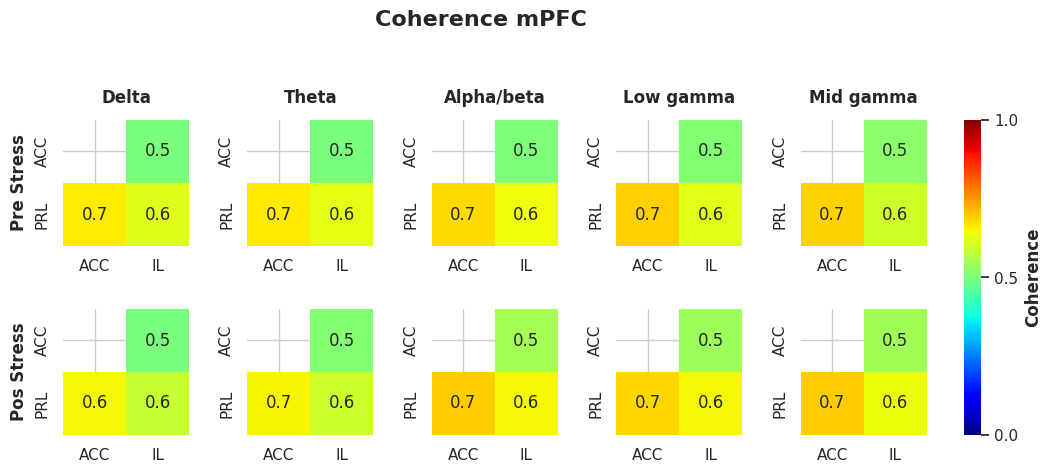

In [ ]:
canais = ['PRL', 'AC', 'IL']

f, axs = plt.subplots( 2,5, figsize=(11.5,5), gridspec_kw={'hspace': 0.5})
plt.suptitle('Coherence mPFC', fontsize=16, fontweight='bold', y=1.1, x=0.5)
bandas_coh = ['Delta', 'Theta', 'Alpha/beta', 'Low gamma',  'Mid gamma']
heatmap_pre = []
heatmap_pos = []
for banda in range(len(bandas_coh)):
    for i in range(len(canais)):
        for j in range(len(canais)):
            pre = coh[ (coh.banda == bandas_coh[banda] )  & (coh.condicao == 'OF_pre') ]

            pos = coh[ (coh.banda == bandas_coh[banda] )  & (coh.condicao == 'OF_pos') ]

    # mask = np.tril(np.ones_like(pre, dtype=bool))
    pivot_pre = pre.pivot_table(index='r1', columns='r2', values='coherence')
    pivot_pos = pos.pivot_table(index='r1', columns='r2', values='coherence')
    im1 = sns.heatmap(pivot_pre,  vmin = 0, vmax = 1.0, ax=axs[1,banda], square=True, annot=True,  cmap = 'jet', fmt=".1f", cbar=False)
    im2 = sns.heatmap(pivot_pos,   vmin = 0,vmax = 1.0, ax=axs[0,banda], square=True, annot=True,   cmap = 'jet', fmt=".1f", cbar=False)
    axs[0,banda].set_title( bandas_coh[banda] , fontweight='bold',  pad = 12, fontsize = 12)
    axs[1,banda].set_title( None)
    axs[0,banda].set_ylabel(None)
    axs[0,banda].set_xlabel(None)
    axs[1,banda].set_xlabel(None)
    axs[1,banda].set_ylabel(None)
    heatmap_pre.append(im1)
    heatmap_pos.append(im2)

plt.text(-0.35, 0.5, 'Pre Stress', fontsize=12, fontweight='bold', transform=axs[0, 0].transAxes, ha='center', va='center', rotation='vertical')
plt.text(-0.35, 0.5, 'Pos Stress', fontsize=12, fontweight='bold', transform=axs[1, 0].transAxes, ha='center', va='center', rotation='vertical')


f.subplots_adjust(bottom=0.25)

cax = f.add_axes([0.92, 0.25, 0.015, 0.63])  # Posição e tamanho da colorbar
cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=0, vmax=1)

cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical', ticks=[0, 0.5, 1])
cb.outline.set_visible(False)
cb.set_label('Coherence', fontweight='bold')


# plt.tight_layout()
plt.savefig('/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/FIGURES/heatmap_coherence_mPFC.jpeg', dpi=600)


# > Causalidade de Granger tranform bipolar


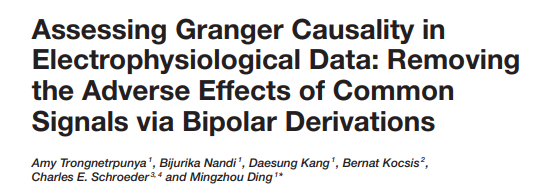

In [ ]:

def load_data_granger(path,inicio,final,ch_prl_1,ch_prl_2,ch_cg_1,ch_cg_2,ch_il_1,ch_il_2):
  load = Session(path).recordnodes[0].recordings[0]
  t_raw= load.continuous[0].timestamps
  t = t_raw-t_raw[0]


  data_prl_1 = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[inicio:final,int(int(ch_prl_1)-1)]
  data_cg_1 = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[inicio:final,int(int(ch_cg_1)-1)]
  data_il_1 = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[inicio:final,int(int(ch_il_1)-1)]

  data_prl_2 = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[inicio:final,int(int(ch_prl_2)-1)]
  data_cg_2 = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[inicio:final,int(int(ch_cg_2)-1)]
  data_il_2 = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[inicio:final,int(int(ch_il_2)-1)]

  data_prl = data_prl_1 - data_prl_2
  data_cg = data_cg_1 - data_cg_2
  data_il = data_il_1 - data_il_2

  srate = 1000
  fc_low = 55
  fc_high = 61
  order = 5
  b, a = signal.butter(order, [fc_low/(0.5*srate), fc_high/(0.5*srate)], btype='bandstop')

  PRL = signal.filtfilt(b, a, data_prl)
  CG = signal.filtfilt(b, a, data_cg)
  IL = signal.filtfilt(b, a, data_il)

  return(pd.DataFrame({'PRL': PRL,'ACC': CG, 'IL': IL}))

In [ ]:
dict_granger = {'CCM497': { 'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/16_12_22/CCM497_OF_PRE_SCREEN',
                                   'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/16_12_22/CCM497_OF_POS_SCREEN'},

                      'canais': {'prl_1': 26,
                                 'prl_2': 32,
                                  'cg_1': 14,
                                  'cg_2': 17,
                                  'il_1': 3,
                                  'il_2': 8 },

                      'inicio': { 'OF_pre': 50000,
                                  'OF_pos': 5000}}}   # VERIFICADO OF PRE E POS OK



         'CCM559': {'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/16_12_22/CCM559_OF_PRE_SCREEN',
                                 'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/16_12_22/CCM559_OF_POS_SCREEN'},

                     'canais': {'prl_1': 28,
                                 'prl_2': 30,
                                  'cg_1': 21,
                                  'cg_2': 10  ,
                                  'il_1': 7
                                  'il_2':2  },

                    'inicio': { 'OF_pre': 23000,
                                'OF_pos': 471000    }  },

        #   # 'CCM56': {'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/09_08_23/CCM56_OF_PRE_SCREEN',
        #   #                        'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/09_08_23/CCM56_OF_POS_SCREEN' },

        #   #           'canais': { 'prl': 4,
        #   #                       'cg': 6,
        #   #                       'il': 24 },

        #   #           'inicio': { 'OF_pre': 40000,
        #   #                       'OF_pos': 140000   } ,
        #   #            'screening': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/09_08_23/CCM56_SCREENING'},

          'CCM04': {'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/29_08_23/CCM04_OF_PRE_SCREEN',
                                 'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/29_08_23/CCM04_OF_POS_SCREEN' },

                     'canais': {'prl_1': 21,
                                 'prl_2':   ,
                                  'cg_1': 29,
                                  'cg_2':   ,
                                  'il_1': 25
                                  'il_2':  },

                    'inicio': { 'OF_pre': 10000,
                               'OF_pos': 490000   }  },

        #   'CCM05': {'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/31_08_23/CCMO5_OF_PRE_SCREEN',
        #                         'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/31_08_23/CCM05_OF_POS_SCREEN_2' },


        #               'canais': {'prl_1': 22,
        #                          'prl_2':   ,
        #                           'cg_1': 29,
        #                           'cg_2':   ,
        #                           'il_1': 27
        #                           'il_2':  },

        #             'inicio': { 'OF_pre': 590000 ,
        #                         'OF_pos':  242000  } },

        #   'CCM192': {'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/26_10_2023/CCM192_OF_PRE_SCREEN',
        #                           'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/26_10_2023/CCM192_OF_POS_SCREEN' },

        #               'canais': {'prl_1': 24,
        #                          'prl_2':   ,
        #                           'cg_1': 31,
        #                           'cg_2':   ,
        #                           'il_1': 27
        #                           'il_2':  },

        #               'inicio': { 'OF_pre': 136000 ,
        #                           'OF_pos':  170000  }   },

        #   'CCM193': {'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/31_10_2023/CCM193_OF_PRE_SCREEN',
        #                         'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/31_10_2023/CCM193_OF_POS_SCREEN' },


        #               'canais': {'prl_1': 21,
        #                          'prl_2':   ,
        #                           'cg_1': 29,
        #                           'cg_2':   ,
        #                           'il_1': 28
        #                           'il_2':  },

        #             'inicio': { 'OF_pre': 200000,
        #                         'OF_pos':  390000 }  } }



In [ ]:
dataframes_granger = []

for condicao in dict_granger['CCM497']['condicao'].keys():
      path = dict_granger['CCM497']['condicao'][str(condicao)]
      inicio = dict_granger['CCM497']['inicio'][str(condicao)]
      final = inicio + 15000

      ch_prl_1 =  dict_granger['CCM497']['canais']['prl_1']
      ch_cg_1 =  dict_granger['CCM497']['canais']['cg_1']
      ch_il_1 =  dict_granger['CCM497']['canais']['il_1']

      ch_prl_2 =  dict_granger['CCM497']['canais']['prl_2']
      ch_cg_2 =  dict_granger['CCM497']['canais']['cg_2']
      ch_il_2 =  dict_granger['CCM497']['canais']['il_2']

      df_temp_granger = load_data_granger(path,inicio,final, ch_prl_1,ch_prl_2,ch_cg_1,ch_cg_2,ch_il_1,ch_il_2)
      df_temp_granger['animal'] = 'CCM497'
      df_temp_granger['condicao'] = str(condicao)

      dataframes_granger.append(df_temp_granger)

df_GRANGER = pd.concat(dataframes_granger)

/usr/local/lib/python3.10/dist-packages/open_ephys/analysis/formats/BinaryRecording.py:141: ResourceWarning: unclosed file <_io.TextIOWrapper name='/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/16_12_22/CCM497_OF_PRE_SCREEN/Record Node 101/experiment1/recording1/structure.oebin' mode='r' encoding='UTF-8'>
  self.info = json.load(open(os.path.join(self.directory, 'structure.oebin')))
/usr/local/lib/python3.10/dist-packages/open_ephys/analysis/formats/BinaryRecording.py:141: ResourceWarning: unclosed file <_io.TextIOWrapper name='/content/drive/Shareddrives/Stress 1K/PROJETO LH PFC/SCREENING/16_12_22/CCM497_OF_PRE_SCREEN/Record Node 101/experiment1/recording2/structure.oebin' mode='r' encoding='UTF-8'>
  self.info = json.load(open(os.path.join(self.directory, 'structure.oebin')))
/usr/local/lib/python3.10/dist-packages/open_ephys/analysis/formats/BinaryRecording.py:141: ResourceWarning: unclosed file <_io.TextIOWrapper name='/content/drive/Shareddrives/Stress 1K/PROJETO 

In [ ]:
faz_df_granger = []

for condicao in dict_granger['CCM497']['condicao'].keys():
  prl = df_GRANGER[( df_GRANGER  ['animal'] == 'CCM497') & (df_GRANGER['condicao'] == str(condicao))]['PRL']
  acc =  df_GRANGER[( df_GRANGER  ['animal'] == 'CCM497') & (df_GRANGER['condicao'] == str(condicao))]['ACC']
  il = df_GRANGER[( df_GRANGER  ['animal'] == 'CCM497') & (df_GRANGER['condicao'] == str(condicao))]['IL']

  gc_prl_cg = grangercausality(prl,acc,'PRL','ACC',str(condicao),'CCM497',1000,1,100)
  faz_df_granger.append(gc_prl_cg)

  gc_cg_prl = grangercausality(acc,prl,'ACC','PRL',str(condicao),'CCM497',1000,1,100)
  faz_df_granger.append(gc_cg_prl)

df_final_granger = pd.concat(faz_df_granger)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [ ]:
df_final_granger

,Granger Causality,P value,r1,r2,regioes,condicao
Results,1193.159361,p<0.01,PRL,ACC,PRL->ACC,OF_pre
Results,212.130041,p<0.01,ACC,PRL,ACC->PRL,OF_pre
Results,484.209626,p<0.01,PRL,ACC,PRL->ACC,OF_pos
Results,5.466058,p<0.01,ACC,PRL,ACC->PRL,OF_pos


In [ ]:
df_final_granger['Granger Causality'] = np.log10(df_final_granger['Granger Causality'])
df_final_granger.rename(columns={'condicao': 'Condition', 'regioes': 'Direction'}, inplace=True)

In [ ]:
prl

NameError: ignored

In [ ]:
surrogatos = np.copy(prl)
np.random.shuffle(surrogatos)

In [ ]:
surrogatos

array([ 12.16450248, -17.85080738, -36.74035835, ...,   2.94488471,
       -10.76711736,  20.77259416])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Defina os parâmetros do sinal
fs = 1000  # Taxa de amostragem (Hz)
duracao = 15  # Duração do sinal em segundos
frequencia = 10  # Frequência do sinal em Hz

# Crie um vetor de tempo
tempo = np.arange(0, duracao, 1/fs)

# Gere o sinal de LFP (neste exemplo, uma senoide)
sinal_lfp = np.sin(2 * np.pi * frequencia * tempo)



In [ ]:
prl = np.mean(data_prl_pre,axis = 0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
sinal_fake = np.random.rand(3,15000)

In [ ]:
sinal_fake

array([[0.05165187, 0.91625663, 0.81712878, ..., 0.6280472 , 0.0251632 ,
        0.40134024],
       [0.06942471, 0.72261124, 0.87613886, ..., 0.11664898, 0.65873176,
        0.89037943],
       [0.62321098, 0.76415684, 0.05018338, ..., 0.97447855, 0.9494869 ,
        0.27032281]])

In [ ]:
sinal_lfp

array([ 0.        ,  0.06279052,  0.12533323, ..., -0.18738131,
       -0.12533323, -0.06279052])

In [ ]:
for i in range(1, 31):
  gc_prl_x = grangercausality(prl[0:len(sinal_fake[2])],sinal_fake[2],'PRL','x',str(condicao),'CCM497',1000,1,100, lag=i)
  gc_x_prl = grangercausality(sinal_fake[2],prl[0:len(sinal_fake[2])],'PRL','x',str(condicao),'CCM497',1000,1,100, lag=i)
  print(gc_prl_x)
  print(gc_x_prl)

Lag: [1]
{1: ({'ssr_ftest': (503.6991058138977, 9.488766496056339e-110, 14995.0, 1), 'ssr_chi2test': (503.7998792261979, 1.4164441820766331e-111, 1), 'lrtest': (495.5231146136066, 8.954861608351254e-110, 1), 'params_ftest': (503.69910581389854, 9.488766496048248e-110, 14995.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b42530>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b43520>, array([[0., 1., 0.]])])}
[9.488766496056339e-110, 503.6991058138977]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [1]
{1: ({'ssr_ftest': (3169.7495530183514, 0.0, 14995.0, 1), 'ssr_chi2test': (3170.383714316054, 0.0, 1), 'lrtest': (2876.1074584659073, 0.0, 1), 'params_ftest': (3169.749553018338, 0.0, 14995.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b421a0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b43d00>, array([[0., 1., 0.]])])}
[0.0, 3169.7495530183514]
         Granger Causality P value   r1 r2 regioes condicao
Results         503.699106  p<0.01  PRL  x  PRL->x   OF_pos
         Granger Causality P value   r1 r2 regioes condicao
Results        3169.749553  p<0.01  PRL  x  PRL->x   OF_pos


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [2]
{2: ({'ssr_ftest': (35.55424351538795, 3.9399612255849616e-16, 14992.0, 2), 'ssr_chi2test': (71.13220250804072, 3.5796328306588775e-16, 2), 'lrtest': (70.96404062374495, 3.893627241648811e-16, 2), 'params_ftest': (35.55424351538918, 3.939961225577935e-16, 14992.0, 2.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b42c80>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b43400>, array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]])])}
[3.9399612255849616e-16, 35.55424351538795]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [2]
{2: ({'ssr_ftest': (843.6503973070203, 0.0, 14992.0, 2), 'ssr_chi2test': (1687.8635283368974, 0.0, 2), 'lrtest': (1599.4563212615321, 0.0, 2), 'params_ftest': (843.6503973070226, 0.0, 14992.0, 2.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b421a0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b41780>, array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]])])}
[0.0, 843.6503973070203]
         Granger Causality P value   r1 r2 regioes condicao
Results          35.554244  p<0.01  PRL  x  PRL->x   OF_pos
         Granger Causality P value   r1 r2 regioes condicao
Results         843.650397  p<0.01  PRL  x  PRL->x   OF_pos


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [3]
{3: ({'ssr_ftest': (594.0891843587465, 0.0, 14989.0, 3), 'ssr_chi2test': (1783.0998883135155, 0.0, 3), 'lrtest': (1684.8089796237182, 0.0, 3), 'params_ftest': (594.0891843587476, 0.0, 14989.0, 3.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b42f80>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b41810>, array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.]])])}
[0.0, 594.0891843587465]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [3]
{3: ({'ssr_ftest': (1322.2444618441948, 0.0, 14989.0, 3), 'ssr_chi2test': (3968.585886279714, 0.0, 3), 'lrtest': (3520.9084458316793, 0.0, 3), 'params_ftest': (1322.2444618442107, 0.0, 14989.0, 3.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b42f80>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b43970>, array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.]])])}
[0.0, 1322.2444618441948]
         Granger Causality P value   r1 r2 regioes condicao
Results         594.089184  p<0.01  PRL  x  PRL->x   OF_pos
         Granger Causality P value   r1 r2 regioes condicao
Results        1322.244462  p<0.01  PRL  x  PRL->x   OF_pos


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [4]
{4: ({'ssr_ftest': (658.1230110144114, 0.0, 14986.0, 4), 'ssr_chi2test': (2634.073014856826, 0.0, 4), 'lrtest': (2426.679879600648, 0.0, 4), 'params_ftest': (658.1230110144068, 0.0, 14986.0, 4.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b43a60>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b413c0>, array([[0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.]])])}
[0.0, 658.1230110144114]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [4]
{4: ({'ssr_ftest': (2319.998103392574, 0.0, 14986.0, 4), 'ssr_chi2test': (9285.565610669066, 0.0, 4), 'lrtest': (7226.981938524696, 0.0, 4), 'params_ftest': (2319.9981033925933, 0.0, 14986.0, 4.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b40eb0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b41210>, array([[0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.]])])}
[0.0, 2319.998103392574]
         Granger Causality P value   r1 r2 regioes condicao
Results         658.123011  p<0.01  PRL  x  PRL->x   OF_pos
         Granger Causality P value   r1 r2 regioes condicao
Results        2319.998103  p<0.01  PRL  x  PRL->x   OF_pos


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [5]
{5: ({'ssr_ftest': (2506.861491503344, 0.0, 14983.0, 5), 'ssr_chi2test': (12543.509712207548, 0.0, 5), 'lrtest': (9114.836762404186, 0.0, 5), 'params_ftest': (2506.8614915033386, 0.0, 14983.0, 5.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b429b0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b43640>, array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])])}
[0.0, 2506.861491503344]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [5]
{5: ({'ssr_ftest': (954.5766820332378, 0.0, 14983.0, 5), 'ssr_chi2test': (4776.387495964216, 0.0, 5), 'lrtest': (4146.3675309546525, 0.0, 5), 'params_ftest': (954.576682033261, 0.0, 14983.0, 5.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b43b80>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b42c50>, array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])])}
[0.0, 954.5766820332378]
         Granger Causality P value   r1 r2 regioes condicao
Results        2506.861492  p<0.01  PRL  x  PRL->x   OF_pos
         Granger Causality P value   r1 r2 regioes condicao
Results         954.576682  p<0.01  PRL  x  PRL->x   OF_pos


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [6]
{6: ({'ssr_ftest': (3735.819155792822, 0.0, 14980.0, 6), 'ssr_chi2test': (22434.367130628216, 0.0, 6), 'lrtest': (13715.877560372348, 0.0, 6), 'params_ftest': (3735.8191557928235, 0.0, 14980.0, 6.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b43ca0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b42380>, array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])])}
[0.0, 3735.819155792822]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [6]
{6: ({'ssr_ftest': (3029.8623242771514, 0.0, 14980.0, 6), 'ssr_chi2test': (18194.950264841387, 0.0, 6), 'lrtest': (11913.48938640824, 0.0, 6), 'params_ftest': (3029.8623242771732, 0.0, 14980.0, 6.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b421d0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b40070>, array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])])}
[0.0, 3029.8623242771514]
         Granger Causality P value   r1 r2 regioes condicao
Results        3735.819156  p<0.01  PRL  x  PRL->x   OF_pos
         Granger Causality P value   r1 r2 regioes condicao
Results        3029.862324  p<0.01 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [7]
{7: ({'ssr_ftest': (4142.627377440709, 0.0, 14977.0, 7), 'ssr_chi2test': (29027.434566210715, 0.0, 7), 'lrtest': (16148.100667811581, 0.0, 7), 'params_ftest': (4142.627377440778, 0.0, 14977.0, 7.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b42bf0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b43790>, array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])])}
[0.0, 4142.627377440709]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [7]
{7: ({'ssr_ftest': (3506.6783223702214, 0.0, 14977.0, 7), 'ssr_chi2test': (24571.33270099623, 0.0, 7), 'lrtest': (14548.027240644617, 0.0, 7), 'params_ftest': (3506.6783223703724, 0.0, 14977.0, 7.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b404f0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b42dd0>, array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])])}
[0.0, 3506.6783223702214]
         Granger Causality P value   r1 r2 regioes condicao
Results        4142.627377  p<0.01  PR

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [8]
{8: ({'ssr_ftest': (3114.22824518025, 0.0, 14974.0, 8), 'ssr_chi2test': (24942.110657671765, 0.0, 8), 'lrtest': (14687.519194536959, 0.0, 8), 'params_ftest': (3114.2282451795363, 0.0, 14974.0, 8.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b41510>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b42890>, array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0.],
       [0., 0., 0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [8]
{8: ({'ssr_ftest': (2332.3441046210705, 0.0, 14974.0, 8), 'ssr_chi2test': (18679.93614124454, 0.0, 8), 'lrtest': (12130.492562549363, 0.0, 8), 'params_ftest': (2332.344104621686, 0.0, 14974.0, 8.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b41510>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b40a60>, array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0.],
       [0., 0., 0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [9]
{9: ({'ssr_ftest': (4030.3019137339857, 0.0, 14971.0, 9), 'ssr_chi2test': (36318.75166534313, 0.0, 9), 'lrtest': (18444.86556892295, 0.0, 9), 'params_ftest': (4030.3019137325773, 0.0, 14971.0, 9.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b43eb0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b429b0>, array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [9]
{9: ({'ssr_ftest': (2961.71259732371, 0.0, 14971.0, 9), 'ssr_chi2test': (26689.242302113536, 0.0, 9), 'lrtest': (15329.072394437913, 0.0, 9), 'params_ftest': (2961.712597323007, 0.0, 14971.0, 9.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b43ca0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b41f30>, array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [10]
{10: ({'ssr_ftest': (4054.6935673429066, 0.0, 14968.0, 10), 'ssr_chi2test': (40603.82274245245, 0.0, 10), 'lrtest': (19646.644489569357, 0.0, 10), 'params_ftest': (4054.693567345007, 0.0, 14968.0, 10.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b41210>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b40070>, array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0.],


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [10]
{10: ({'ssr_ftest': (3194.019896799106, 0.0, 14968.0, 10), 'ssr_chi2test': (31985.01084521767, 0.0, 10), 'lrtest': (17121.60328245355, 0.0, 10), 'params_ftest': (3194.019896799457, 0.0, 14968.0, 10.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b42ad0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b437f0>, array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0.],
  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [11]
{11: ({'ssr_ftest': (3484.8424977530776, 0.0, 14965.0, 11), 'ssr_chi2test': (38392.18262075205, 0.0, 11), 'lrtest': (19037.602986560087, 0.0, 11), 'params_ftest': (3484.8424977510335, 0.0, 14965.0, 11.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b404f0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b43850>, array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [11]
{11: ({'ssr_ftest': (2366.222611567535, 0.0, 14965.0, 11), 'ssr_chi2test': (26068.45235709431, 0.0, 11), 'lrtest': (15103.37950487266, 0.0, 11), 'params_ftest': (2366.2226115661924, 0.0, 14965.0, 11.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b43970>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b42ce0>, array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [12]
{12: ({'ssr_ftest': (3530.073218748187, 0.0, 14962.0, 12), 'ssr_chi2test': (42431.65940065158, 0.0, 12), 'lrtest': (20130.331107355887, 0.0, 12), 'params_ftest': (3530.073218750676, 0.0, 14962.0, 12.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b42d10>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b41ff0>, array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [12]
{12: ({'ssr_ftest': (1248.8279133088545, 0.0, 14962.0, 12), 'ssr_chi2test': (15010.974952621149, 0.0, 12), 'lrtest': (10400.179479776183, 0.0, 12), 'params_ftest': (1248.827913308435, 0.0, 14962.0, 12.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b41210>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b437f0>, array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [13]
{13: ({'ssr_ftest': (2825.169212126342, 0.0, 14959.0, 13), 'ssr_chi2test': (36793.4899102901, 0.0, 13), 'lrtest': (18580.807080885745, 0.0, 13), 'params_ftest': (2825.169212125538, 0.0, 14959.0, 13.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b42890>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b41600>, array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [13]
{13: ({'ssr_ftest': (1071.0467638391733, 0.0, 14959.0, 13), 'ssr_chi2test': (13948.73911609199, 0.0, 13), 'lrtest': (9859.686331746401, 0.0, 13), 'params_ftest': (1071.0467638396128, 0.0, 14959.0, 13.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b41930>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b413c0>, array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [14]
{14: ({'ssr_ftest': (3231.6378062195286, 0.0, 14956.0, 14), 'ssr_chi2test': (45330.65628288278, 0.0, 14), 'lrtest': (20867.242006554152, 0.0, 14), 'params_ftest': (3231.6378062229082, 0.0, 14956.0, 14.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b40130>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b402e0>, array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [14]
{14: ({'ssr_ftest': (1032.9073930769557, 0.0, 14956.0, 14), 'ssr_chi2test': (14488.743112704902, 0.0, 14), 'lrtest': (10136.604782349663, 0.0, 14), 'params_ftest': (1032.9073930765608, 0.0, 14956.0, 14.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b42d10>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b43ca0>, array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [15]
{15: ({'ssr_ftest': (2639.4733859608186, 0.0, 14953.0, 15), 'ssr_chi2test': (39674.18165107695, 0.0, 15), 'lrtest': (19391.03336884163, 0.0, 15), 'params_ftest': (2639.4733859524927, 0.0, 14953.0, 15.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b42800>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b40130>, array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [15]
{15: ({'ssr_ftest': (1004.1315215591343, 0.0, 14953.0, 15), 'ssr_chi2test': (15093.198741766271, 0.0, 15), 'lrtest': (10440.617489567026, 0.0, 15), 'params_ftest': (1004.1315215585854, 0.0, 14953.0, 15.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b41030>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b411b0>, array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [16]
{16: ({'ssr_ftest': (2352.0562263462843, 0.0, 14950.0, 16), 'ssr_chi2test': (37715.968898297135, 0.0, 16), 'lrtest': (18843.814417663845, 0.0, 16), 'params_ftest': (2352.056226352925, 0.0, 14950.0, 16.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b41210>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b43b20>, array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [16]
{16: ({'ssr_ftest': (584.3808364434715, 0.0, 14950.0, 16), 'ssr_chi2test': (9370.732385212075, 0.0, 16), 'lrtest': (7278.275330234203, 0.0, 16), 'params_ftest': (584.3808364440631, 0.0, 14950.0, 16.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b416c0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b437f0>, array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [17]
{17: ({'ssr_ftest': (2493.8379467207483, 0.0, 14947.0, 17), 'ssr_chi2test': (42494.51809741715, 0.0, 17), 'lrtest': (20143.7035582409, 0.0, 17), 'params_ftest': (2493.8379467350687, 0.0, 14947.0, 17.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b40130>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b429b0>, array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [17]
{17: ({'ssr_ftest': (639.3341038998884, 0.0, 14947.0, 17), 'ssr_chi2test': (10894.129943043969, 0.0, 17), 'lrtest': (8187.235105131986, 0.0, 17), 'params_ftest': (639.334103900212, 0.0, 14947.0, 17.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b429b0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b43f10>, array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [18]
{18: ({'ssr_ftest': (2266.9165857429693, 0.0, 14944.0, 18), 'ssr_chi2test': (40905.52681198324, 0.0, 18), 'lrtest': (19723.094676670386, 0.0, 18), 'params_ftest': (2266.9165857502794, 0.0, 14944.0, 18.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b42c80>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b43d00>, array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [18]
{18: ({'ssr_ftest': (616.7477608572593, 0.0, 14944.0, 18), 'ssr_chi2test': (11128.945911218336, 0.0, 18), 'lrtest': (8322.44855599117, 0.0, 18), 'params_ftest': (616.7477608555323, 0.0, 14944.0, 18.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b40130>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b43ca0>, array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [19]
{19: ({'ssr_ftest': (2184.600014249603, 0.0, 14941.0, 19), 'ssr_chi2test': (41615.74567001686, 0.0, 19), 'lrtest': (19911.683235026314, 0.0, 19), 'params_ftest': (2184.6000142551366, 0.0, 14941.0, 19.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b41510>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b43f10>, array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [19]
{19: ({'ssr_ftest': (535.1296263217879, 0.0, 14941.0, 19), 'ssr_chi2test': (10194.002693508284, 0.0, 19), 'lrtest': (7776.055754742643, 0.0, 19), 'params_ftest': (535.1296263222029, 0.0, 14941.0, 19.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b41930>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b411b0>, array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [20]
{20: ({'ssr_ftest': (2073.724476727314, 0.0, 14938.0, 20), 'ssr_chi2test': (41588.32365363294, 0.0, 20), 'lrtest': (19903.82973769307, 0.0, 20), 'params_ftest': (2073.72447670874, 0.0, 14938.0, 20.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b43d00>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b43f10>, array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [20]
{20: ({'ssr_ftest': (538.5025882853257, 0.0, 14938.0, 20), 'ssr_chi2test': (10799.612089872666, 0.0, 20), 'lrtest': (8132.038272904756, 0.0, 20), 'params_ftest': (538.5025882849536, 0.0, 14938.0, 20.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b43ca0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b43f10>, array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [21]
{21: ({'ssr_ftest': (1935.2510725886007, 0.0, 14935.0, 21), 'ssr_chi2test': (40757.28167859882, 0.0, 21), 'lrtest': (19681.554998323787, 0.0, 21), 'params_ftest': (1935.2510725873692, 0.0, 14935.0, 21.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b43370>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b42e00>, array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [21]
{21: ({'ssr_ftest': (532.5889631035782, 0.0, 14935.0, 21), 'ssr_chi2test': (11216.569620132124, 0.0, 21), 'lrtest': (8372.247643119714, 0.0, 21), 'params_ftest': (532.5889631030652, 0.0, 14935.0, 21.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b43f10>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b42c80>, array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Lag: [22]
{22: ({'ssr_ftest': (1769.3020985804676, 0.0, 14932.0, 22), 'ssr_chi2test': (39041.95189322747, 0.0, 22), 'lrtest': (19212.783981645363, 0.0, 22), 'params_ftest': (1769.3020985823512, 0.0, 14932.0, 22.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b413c0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b42800>, array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [22]
{22: ({'ssr_ftest': (511.8107500934586, 0.0, 14932.0, 22), 'ssr_chi2test': (11293.769842706537, 0.0, 22), 'lrtest': (8416.193611073482, 0.0, 22), 'params_ftest': (511.8107500937726, 0.0, 14932.0, 22.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b41930>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b41600>, array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [23]
{23: ({'ssr_ftest': (1621.8005511279132, 0.0, 14929.0, 23), 'ssr_chi2test': (37418.84628809079, 0.0, 23), 'lrtest': (18755.333078587428, 0.0, 23), 'params_ftest': (1621.8005511206006, 0.0, 14929.0, 23.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b42e00>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b411b0>, array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])])}
[0.0, 1621.8005511279132]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [23]
{23: ({'ssr_ftest': (447.8890045168048, 0.0, 14929.0, 23), 'ssr_chi2test': (10333.878479992254, 0.0, 23), 'lrtest': (7858.593902699533, 0.0, 23), 'params_ftest': (447.88900451748384, 0.0, 14929.0, 23.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b41510>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b411b0>, array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])])}
[0.0, 447.8890045168048]
         Granger Causality P value   r1 r2 regioes condicao
Results        1621.800551  p<0.01  PRL  x  PRL->x   OF_pos
         Granger Causality P value   r1 r2 regioes condicao
Results         447.889005  p<0.01  PRL  x  PRL->x   OF_pos


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [24]
{24: ({'ssr_ftest': (1511.4006559198406, 0.0, 14926.0, 24), 'ssr_chi2test': (36392.69702114369, 0.0, 24), 'lrtest': (18458.59483985114, 0.0, 24), 'params_ftest': (1511.4006559126426, 0.0, 14926.0, 24.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b42e00>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b41510>, array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])])}
[0.0, 1511.4006559198406]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [24]
{24: ({'ssr_ftest': (477.4924937017208, 0.0, 14926.0, 24), 'ssr_chi2test': (11497.44085732269, 0.0, 24), 'lrtest': (8531.588151008415, 0.0, 24), 'params_ftest': (477.49249370071544, 0.0, 14926.0, 24.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b43ca0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b41600>, array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])])}
[0.0, 477.4924937017208]
         Granger Causality P value   r1 r2 regioes condicao
Results        1511.400656  p<0.01  PRL  x  PRL->x   OF_pos
         Granger Causality P value   r1 r2 regioes condicao
Results         477.492494  p<0.01  PRL  x  PRL->x   OF_pos


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [25]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{25: ({'ssr_ftest': (1483.4802705196314, 0.0, 14923.0, 25), 'ssr_chi2test': (37213.75321778624, 0.0, 25), 'lrtest': (18695.525518259616, 0.0, 25), 'params_ftest': (1483.4802705188768, 0.0, 14923.0, 25.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b411b0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b43d00>, array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])])}
[0.0, 1483.4802705196314]
Lag: [25]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{25: ({'ssr_ftest': (478.56420381902615, 0.0, 14923.0, 25), 'ssr_chi2test': (12004.99294375477, 0.0, 25), 'lrtest': (8815.840081525384, 0.0, 25), 'params_ftest': (478.56420381692874, 0.0, 14923.0, 25.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b40130>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b42c80>, array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])])}
[0.0, 478.56420381902615]
         Granger Causality P value   r1 r2 regioes condicao
Results        1483.480271  p<0.01  PRL  x  PRL->x   OF_pos
         Granger Causality P value   r1 r2 regioes condicao
Results         478.564204  p<0.01  PRL  x  PRL->x   OF_pos
Lag: [26]
{26: ({'ssr_ftest': (1518.0424384103524, 0.0, 14920.0, 26), 'ssr_chi2test': (39609.308658731454,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [26]
{26: ({'ssr_ftest': (444.8328841742598, 0.0, 14920.0, 26), 'ssr_chi2test': (11606.739419790281, 0.0, 26), 'lrtest': (8593.014738825033, 0.0, 26), 'params_ftest': (444.83288417481486, 0.0, 14920.0, 26.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b43f10>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b43ca0>, array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])])}
[0.0, 444.8328841742598]
         Granger Causality P value   r1 r2 regioes condicao
Results        1518.042438  p<0.01  PRL  x  PRL->x   OF_pos
         Granger Causality P value   r1 r2 regioes condicao
Results         444.832884  p<0.01  PRL  x  PRL->x   OF_pos


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Lag: [27]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{27: ({'ssr_ftest': (1405.1171927678517, 0.0, 14917.0, 27), 'ssr_chi2test': (38078.04481284759, 0.0, 27), 'lrtest': (18940.38728643651, 0.0, 27), 'params_ftest': (1405.1171927628775, 0.0, 14917.0, 27.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b411b0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x79f5f2b41510>, array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])])}
[0.0, 1405.1171927678517]


KeyboardInterrupt: ignored

In [ ]:
gc_x_prl

,Granger Causality,P value,r1,r2,regioes,condicao
Results,83.228468,p<0.01,PRL,x,PRL->x,OF_pos


In [ ]:
gc_prl_x

,Granger Causality,P value,r1,r2,regioes,condicao
Results,276.266822,p<0.01,PRL,x,PRL->x,OF_pos


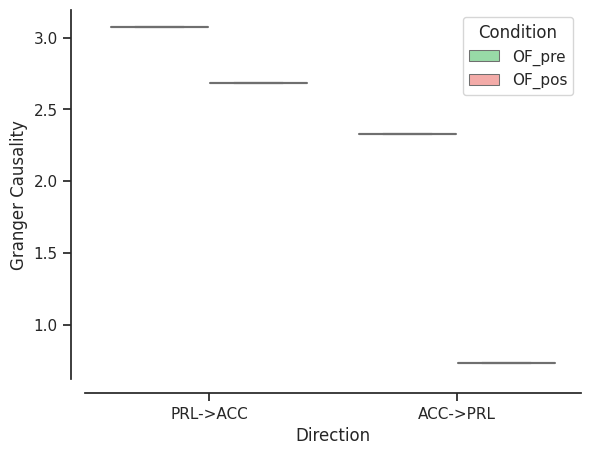

In [ ]:
sns.set_theme(style="ticks", palette="pastel")





sns.boxplot(x="Direction", y="Granger Causality",
            hue="Condition", palette=["g", "r"],
            data=df_final_granger)

sns.despine(offset=10, trim=False)

# > Causalidade de Granger Normal

In [ ]:


fazendo_df_granger = []

for rato in ratos.keys():
  for condicao in ratos[rato]['condicao'].keys():
    for i in range(1,31):
      prl = df[(df['animal'] == str(rato)) & (df['condicao'] == str(condicao) )]['data_PRL'][30000:45000]
      cg = df[(df['animal'] == str(rato)) & (df['condicao'] == str(condicao) )]['data_CG'][30000:45000]
      il = df[(df['animal'] == str(rato)) & (df['condicao'] == str(condicao) )]['data_IL'][30000:45000]

      gc_prl_cg = grangercausality(prl,cg,'PRL','AC',str(condicao),str(rato),1000,1,100,lag=i)
      fazendo_df_granger.append(gc_prl_cg)

      gc_cg_prl = grangercausality(cg,prl,'AC','PRL',str(condicao),str(rato),1000,1,100,lag=1)
      fazendo_df_granger.append(gc_cg_prl)

      gc_prl_il = grangercausality(prl,il,'PRL','IL',str(condicao),str(rato),1000,1,100,lag=1)
      fazendo_df_granger.append(gc_prl_il)




df_granger_animals = pd.concat(fazendo_df_granger)



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


UnboundLocalError: ignored

In [ ]:

fazendo_df_granger_2 = []


for rato in ratos.keys():
  for condicao in ratos[rato]['condicao'].keys():
    prl = df[(df['animal'] == str(rato)) & (df['condicao'] == str(condicao) )]['data_PRL'][30000:45000]
    cg = df[(df['animal'] == str(rato)) & (df['condicao'] == str(condicao) )]['data_CG'][30000:45000]
    il = df[(df['animal'] == str(rato)) & (df['condicao'] == str(condicao) )]['data_IL'][30000:45000]




    gc_il_prl = grangercausality(il,prl,'IL','PRL',str(condicao),str(rato),1000,1,100)
    fazendo_df_granger_2.append(gc_il_prl)

    gc_cg_il = grangercausality(cg,il,'AC','IL',str(condicao),str(rato),1000,1,100)
    fazendo_df_granger_2.append(gc_cg_il)

    gc_il_cg = grangercausality(il,cg,'IL','AC',str(condicao),str(rato),1000,1,100)
    fazendo_df_granger_2.append(gc_il_cg)

df_temp = pd.DataFrame(pd.concat(fazendo_df_granger_2))
df_granger_animals = pd.concat([df_granger_animals, df_temp], axis=0)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print resul

In [ ]:

df_granger_animals['Granger Causality'] = np.log10(df_granger_animals['Granger Causality'])
df_granger_animals.rename(columns={'condicao': 'Condition', 'regioes': 'Direction'}, inplace=True)

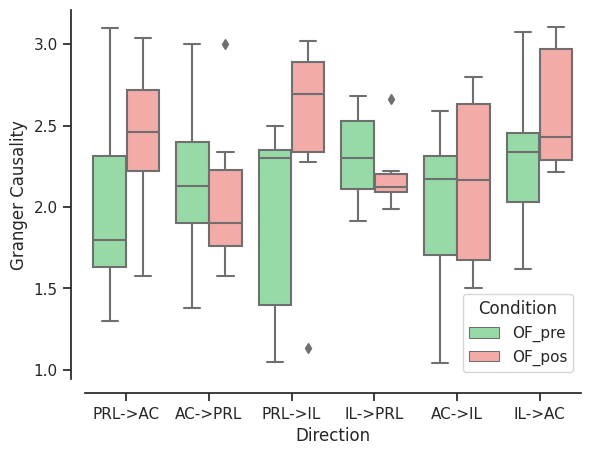

In [ ]:
sns.set_theme(style="ticks", palette="pastel")





sns.boxplot(x="Direction", y="Granger Causality",
            hue="Condition", palette=["g", "r"],
            data=df_granger_animals)

sns.despine(offset=10, trim=False)

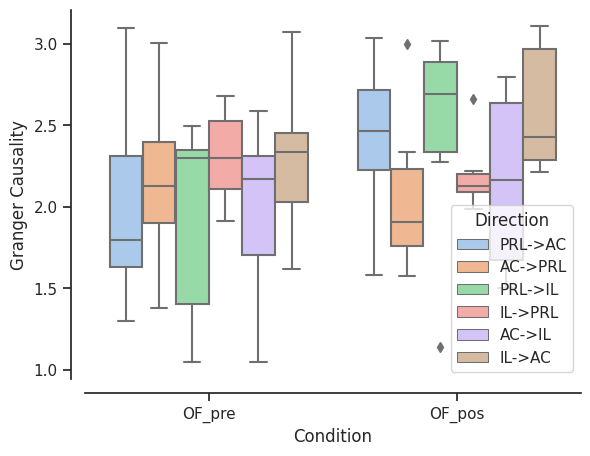

In [ ]:
sns.set_theme(style="ticks", palette="pastel")





sns.boxplot(x="Condition", y="Granger Causality",
            hue="Direction",
            data=df_granger_animals)

sns.despine(offset=10, trim=False)

In [ ]:
prl_ac = df_granger_animals[df_granger_animals['regioes'] == 'PRL->AC']
ac_prl = df_granger_animals[df_granger_animals['regioes'] == 'AC->PRL']

In [ ]:
gc_pre_PRL_AC  = np.array( prl_ac[prl_ac['condicao'] == 'OF_pre' ]['Granger Causality']   )
gc_pre_AC_PRL = np.array( ac_prl[ac_prl['condicao']== 'OF_pre' ]['Granger Causality']   )

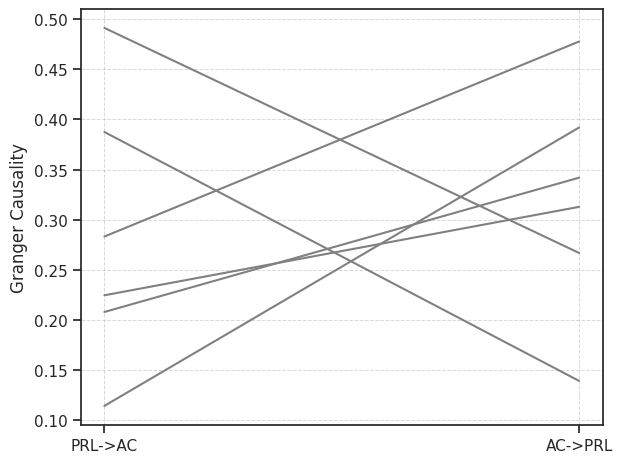

In [ ]:

for x in range(6):
    plt.plot([1.4,1.6], [gc_pre_PRL_AC[x] ,gc_pre_AC_PRL[x]], color = 'grey')

plt.xticks(ticks = [1.4,1.6], labels = ['PRL->AC','AC->PRL'], rotation = 0)

plt.ylabel('Granger Causality')
plt.grid(color='grey', linestyle='--', linewidth=0.7 ,alpha = 0.3, axis = 'both', which = 'Both')

plt.tight_layout()

In [ ]:
AC_PRL = pd.DataFrame({'granger': [np.mean(np.array(df_granger_animals[ (df_granger_animals.r1 ==   'AC' ) & (df_granger_animals.r2 ==   'PRL' ) & (df_granger_animals.condicao == 'OF_pre') ]['Granger Causality']))], 'condicao': 'PRE', 'REGIAO': 'AC->PRL'})
PRL_AC = pd.DataFrame({'granger':[np.mean(np.array(df_granger_animals[ (df_granger_animals.r2 ==   'AC' ) & (df_granger_animals.r1 ==   'PRL' ) & (df_granger_animals.condicao == 'OF_pre') ]['Granger Causality']))], 'condicao': 'PRE', 'REGIAO': 'PRL->AC'})

AC_IL = pd.DataFrame({'granger':[np.mean(np.array(df_granger_animals[ (df_granger_animals.r1 ==   'AC' ) & (df_granger_animals.r2 ==   'IL' ) & (df_granger_animals.condicao == 'OF_pre') ]['Granger Causality']))], 'condicao': 'PRE', 'REGIAO': 'AC->IL'})
IL_AC = pd.DataFrame({'granger': [np.mean(np.array(df_granger_animals[ (df_granger_animals.r2 ==   'AC' ) & (df_granger_animals.r1 ==   'IL' ) & (df_granger_animals.condicao == 'OF_pre') ]['Granger Causality']))],'condicao': 'PRE', 'REGIAO': 'IL->AC'})

PRL_IL = pd.DataFrame({'granger':[np.mean(np.array(df_granger_animals[ (df_granger_animals.r1 ==   'PRL' ) & (df_granger_animals.r2 ==   'IL' ) & (df_granger_animals.condicao == 'OF_pre') ]['Granger Causality']))], 'condicao': 'PRE', 'REGIAO': 'PRL->IL'})
IL_PRL = pd.DataFrame({'granger':[np.mean(np.array(df_granger_animals[ (df_granger_animals.r2 ==   'PRL' ) & (df_granger_animals.r1 ==   'IL' ) & (df_granger_animals.condicao == 'OF_pre') ]['Granger Causality']))], 'condicao': 'PRE', 'REGIAO': 'IL->PRL'})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
AC_PRL_pos = pd.DataFrame({'granger':[np.mean(np.array(df_granger_animals[ (df_granger_animals.r1 ==   'AC' ) & (df_granger_animals.r2 ==   'PRL' ) & (df_granger_animals.condicao == 'OF_pos') ]['Granger Causality']))], 'condicao': 'POS', 'REGIAO': 'AC->PRL'})
PRL_AC_pos =  pd.DataFrame({'granger':[np.mean(np.array(df_granger_animals[ (df_granger_animals.r2 ==   'AC' ) & (df_granger_animals.r1 ==   'PRL' ) & (df_granger_animals.condicao == 'OF_pos') ]['Granger Causality']))],'condicao': 'POS', 'REGIAO': 'PRL->AC'})

AC_IL_pos = pd.DataFrame({'granger': [np.mean(np.array(df_granger_animals[ (df_granger_animals.r1 ==   'AC' ) & (df_granger_animals.r2 ==   'IL' ) & (df_granger_animals.condicao == 'OF_pos') ]['Granger Causality']))],'condicao': 'POS', 'REGIAO': 'AC->IL'})
IL_AC_pos = pd.DataFrame({'granger':[np.mean(np.array(df_granger_animals[ (df_granger_animals.r2 ==   'AC' ) & (df_granger_animals.r1 ==   'IL' ) & (df_granger_animals.condicao == 'OF_pos') ]['Granger Causality']))],'condicao': 'POS', 'REGIAO': 'IL->AC'})

PRL_IL_pos = pd.DataFrame({'granger':[np.mean(np.array(df_granger_animals[ (df_granger_animals.r1 ==   'PRL' ) & (df_granger_animals.r2 ==   'IL' ) & (df_granger_animals.condicao == 'OF_pos') ]['Granger Causality']))],'condicao': 'POS', 'REGIAO': 'PRL->IL'})
IL_PRL_pos = pd.DataFrame({'granger': [np.mean(np.array(df_granger_animals[ (df_granger_animals.r2 ==   'PRL' ) & (df_granger_animals.r1 ==   'IL' ) & (df_granger_animals.condicao == 'OF_pos') ]['Granger Causality']))],'condicao': 'POS', 'REGIAO': 'IL->PRL'})

In [ ]:
df_barplot_granger = pd.concat([  AC_PRL,  PRL_AC  , AC_IL, IL_AC, PRL_IL,  IL_PRL, AC_PRL_pos   , PRL_AC_pos  , AC_IL_pos, IL_AC_pos, PRL_IL_pos, IL_PRL_pos       ])

In [ ]:

f, axs = plt.subplots( 2,2, figsize=(11.5,5), gridspec_kw={'hspace': 0.5})
labels = ['AC->PRL' , 'PRL->AC',  'AC->IL',  'IL->AC' ,  'IL->PRL' , 'PRL->IL' ]
data_pre = [np.log(AC_PRL), np.log(PRL_AC), np.log(AC_IL), np.log(IL_AC), np.log(PRL_IL), np.log(IL_PRL) ]
data_pos = [np.log(AC_PRL_pos),np.log(PRL_AC_pos),np.log(AC_IL_pos),np.log(IL_AC_pos),np.log(PRL_IL_pos),np.log(IL_PRL_pos)]
plt.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.1, axis='both', which='both')


color = ['darkblue', 'darkblue', 'slateblue', 'slateblue', 'darkgreen' ,'darkgreen' ]

hatch_patterns = [ '','///','','///','', '///', '','///','','///','', '///']
alpha = [0.4, 0.6, 1, 1, 0.4, 0.6, 1, 1,0.35, 0.6,1, 1]




for i in range(len(data_pre)):
    axs[0, 0].bar(labels[i], data_pre[i], width=0.6,  hatch=hatch_patterns[i], color=color[i], align='center')

    axs[1, 0].bar(i+1, data_pos[i], width=0.6,  hatch=hatch_patterns[i], color=color[i], align='center')

    axs[0, 0].set_title(labels[i], fontweight='bold', pad=12, fontsize=12)

plt.text(-0.35, 0.5, 'Pre Stress', fontsize=12, fontweight='bold', transform=axs[0, 0].transAxes, ha='center', va='center', rotation='vertical')
plt.text(-0.35, 0.5, 'Pos Stress', fontsize=12, fontweight='bold', transform=axs[1, 0].transAxes, ha='center', va='center', rotation='vertical')

